# 1. Dependencies

In [26]:
'''
pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
pip install stable-baselines3[extra]==1.5.0 protobuf==3.20.*
pip install mss pydirectinput pytesseract

py-version: 3.10.5, needs pip install exceptiongroup
'''

'\npip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121\npip install stable-baselines3[extra]==1.5.0 protobuf==3.20.*\npip install mss pydirectinput pytesseract\n'

In [27]:
# mss used for screen cap
from mss import mss

# sending commands
import pydirectinput

# opencv allows us to do frame processing
import cv2

# transformational framework
import numpy as np

# ocr for game over extraction
import pytesseract
pytesseract.pytesseract.tesseract_cmd=r"C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

# visualize captured frames
from matplotlib import pyplot as plt

# bring in time for pauses
import time

# environment components
from gym import Env
from gym.spaces import Box, Discrete

# 2. Environment

## 2.1 Environment Creation

In [28]:
class WebGame(Env):

    # setup the environment action and observation shapes
    def __init__(self):

        # subclass model
        super().__init__()
        
        # setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)

        # define extraction parameters for the game
        self.cap = mss()
        self.game_location = {'top': 400, 'left': 0, 'width': 800, 'height': 668}
        self.done_location = {'top': 580, 'left': 840, 'width': 880, 'height': 94}
        
    # what is called to do something in the game
    def step(self, action):

        # action key - 0 = space, 1 = duck (down), 2 = no action (no op)
        action_map = {
            0: 'space',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])
        
        # checking whether the game is done
        done, done_cap = self.get_done() 

        # get the next observtion
        new_observation = self.get_observation()

        # reward - we get a point for every frame we are alive
        reward = 1

        # info dictionary
        info = {}

        return new_observation, reward, done, info
        
    # restart the game
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=200, y=200)
        pydirectinput.press('space')
        return self.get_observation()
        
    # visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    # this closes down the observation
    def close(self):
        cv2.destroyAllWindows()
    

    # get the part of the observation of the game we want
    def get_observation(self):

        # get screen capture of game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)

        # grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)

        # resize
        resized = cv2.resize(gray, (100,83))

        # add channels first
        channel = np.reshape(resized, (1,83,100))
        return channel
    

    # get the done text using ocr
    def get_done(self):

        #get done screen
        done_cap = np.array(self.cap.grab(self.done_location))
        
        # valid done text
        done_strings = ['GAME', 'GAHE']

        # apply ocr
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        
        return done, done_cap

# 2.2 Environment Testing

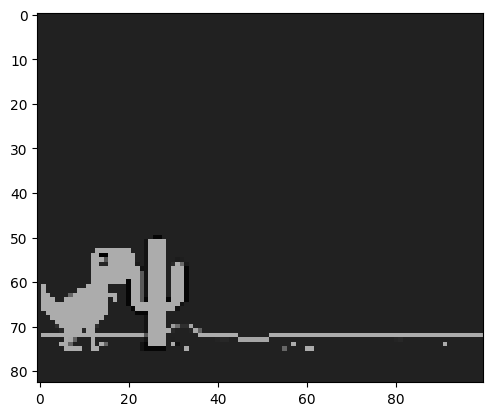

In [29]:
env = WebGame()
obs=env.get_observation()

# env.render()
# env.reset()

plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

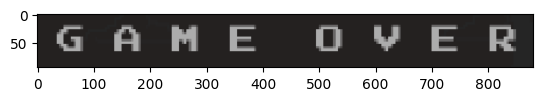

In [30]:
done, done_cap = env.get_done()
plt.imshow(done_cap)

In [31]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [32]:
done

True

In [8]:
'''
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward = 0

    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
'''

"\nfor episode in range(10): \n    obs = env.reset()\n    done = False  \n    total_reward = 0\n\n    while not done: \n        obs, reward,  done, info =  env.step(env.action_space.sample())\n        total_reward  += reward\n    print(f'Total Reward for episode {episode} is {total_reward}')\n"

# 3. Training the Model

## 3.1 Creating Callback

In [9]:
# import os for file path management
import os

# import base callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

# check environment    
from stable_baselines3.common import env_checker

In [10]:
# check that the environment is ok
# env_checker.check_env(env)

In [11]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [12]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [13]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

## 3.2 Building DQN and Training

In [14]:
# import the DQN algorithm
from stable_baselines3 import DQN

In [15]:
# create the DQN model
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1,
            buffer_size=1200000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\shrijeet\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\buffers.py:220: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 9.16GB
  warnings.warn(


In [16]:
# kick off training
model.learn(total_timesteps=200000, callback=callback)

Logging to ./logs/DQN_8


KeyboardInterrupt: 

# 4. Testing out Model

In [17]:
model = DQN.load(os.path.join('train_first', 'best_model_120000')) 

c:\Users\shrijeet\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\buffers.py:220: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 8.98GB
  warnings.warn(


In [18]:
for episode in range(10): 
    obs = env.reset()
    done = False
    total_reward = 0

    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

Total Reward for episode 0 is 118
Total Reward for episode 1 is 99
Total Reward for episode 2 is 73
Total Reward for episode 3 is 129
Total Reward for episode 4 is 118
Total Reward for episode 5 is 47
Total Reward for episode 6 is 118
Total Reward for episode 7 is 189
Total Reward for episode 8 is 102
Total Reward for episode 9 is 97
